# Machine Learning Application: Gender Wage Gap

**Author**

> - [David Tan *UBC*](https://www.linkedin.com/in/zhiweitan/)  

In [8]:
# Uncomment following line to install on colab
# ! pip install fiona geopandas xgboost gensim folium pyLDAvis descartes

In [9]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd


%matplotlib inline
plt.style.use('bmh')

In [10]:
from sklearn.model_selection import cross_val_predict
from sklearn import linear_model
import statsmodels as sm

def partial_linear(y, d, X, yestimator, destimator, folds=3):
    """Estimate the partially linear model y = d*C + f(x) + e

    Parameters
    ----------
    y : array_like
        vector of outcomes
    d : array_like
        vector or matrix of regressors of interest
    X : array_like
        matrix of controls
    mlestimate : Estimator object for partialling out X. Must have ‘fit’
        and ‘predict’ methods.
    folds : int
        Number of folds for cross-fitting

    Returns
    -------
    ols : statsmodels regression results containing estimate of coefficient on d.
    yhat : cross-fitted predictions of y
    dhat : cross-fitted predictions of d
    """

    # we want predicted probabilities if y or d is discrete
    ymethod = "predict" if False==getattr(yestimator, "predict_proba",False) else "predict_proba"
    dmethod = "predict" if False==getattr(destimator, "predict_proba",False) else "predict_proba"
    # get the predictions
    yhat = cross_val_predict(yestimator,X,y,cv=folds,method=ymethod)
    dhat = cross_val_predict(destimator,X,d,cv=folds,method=dmethod)
    ey = np.array(y - yhat)
    ed = np.array(d - dhat)
    ols = sm.regression.linear_model.OLS(ey,ed).fit(cov_type='HC0')

    return(ols, yhat, dhat)

### Gender Wage Gap:

Policy makers have
long been concerned with the gender wage gap. We will examine the
gender wage gap using data from the 2018 Current Population Survey (CPS) in
the US. In particular, we will use the version of the [CPS provided by
the NBER](https://www.nber.org/cps/).

In [11]:
import statsmodels.formula.api as smf
from statsmodels.iolib.summary2 import summary_col
# Download CPS data
cpsall = pd.read_stata("https://www.nber.org/morg/annual/morg18.dta")

# take subset of data just to reduce computation time
cps = cpsall.sample(30000, replace=False, random_state=0)
display(cps.head())
cps.describe()

,hhid,intmonth,hurespli,hrhtype,minsamp,hrlonglk,hrsample,hrhhid2,serial,hhnum,...,ym_file,ym,ch02,ch35,ch613,ch1417,ch05,ihigrdc,docc00,dind02
103153,150909100105603,May,1.0,Civilian male primary individual,MIS 4,MIS 2-4 Or MIS 6-8 (link To,0801,08011,1,1,...,700,697,0,0,0,0,0,NaN,Business and financial operations occupations,Professional and Technical services
76648,505760912076673,March,1.0,Husband/wife primary fam (neither in Armed For...,MIS 4,MIS 2-4 Or MIS 6-8 (link To,0811,08111,1,1,...,698,695,0,0,0,0,0,12.0,NaN,NaN
51433,481462012350753,February,1.0,Husband/wife primary fam (neither in Armed For...,MIS 4,MIS 2-4 Or MIS 6-8 (link To,0701,07011,1,1,...,697,694,0,0,0,0,0,NaN,Management occupations,Agriculture
75550,106518879410166,March,2.0,Husband/wife primary fam (neither in Armed For...,MIS 8,MIS 2-4 Or MIS 6-8 (link To,0611,06111,1,1,...,698,683,0,0,0,0,0,11.0,NaN,NaN
284643,466023401171104,December,1.0,Husband/wife primary fam (neither in Armed For...,MIS 4,MIS 2-4 Or MIS 6-8 (link To,0901,09011,1,1,...,707,704,0,1,1,0,1,13.0,Management occupations,Membership associations and organizations


,hurespli,hhnum,cbsafips,county,centcity,smsastat,icntcity,smsa04,relref95,age,...,recnum,year,ym_file,ym,ch02,ch35,ch613,ch1417,ch05,ihigrdc
count,29997.000000,30000.000000,30000.000000,30000.000000,24701.000000,29689.000000,3845.000000,30000.000000,30000.000000,30000.000000,...,30000.000000,30000.0,30000.000000,30000.000000,30000.00000,30000.000000,30000.000000,30000.000000,30000.000000,21463.000000
mean,1.314898,1.052733,22812.328667,25.752033,1.926157,1.188150,1.377373,3.687667,3.200333,47.856967,...,217052.625000,2018.0,701.467433,692.357833,0.06040,0.065333,0.143033,0.086467,0.105033,12.355938
std,0.683163,0.245943,16494.302775,62.862911,0.721596,0.390839,0.946464,2.592477,3.291772,18.757968,...,125652.429688,0.0,3.467921,6.970577,0.23823,0.247117,0.350113,0.281057,0.306601,2.478719
min,0.000000,1.000000,0.000000,0.000000,1.000000,1.000000,1.000000,0.000000,1.000000,16.000000,...,19.000000,2018.0,696.000000,681.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,1.000000,1.000000,0.000000,0.000000,1.000000,1.000000,1.000000,0.000000,1.000000,32.000000,...,108185.250000,2018.0,698.000000,686.000000,0.00000,0.000000,0.000000,0.000000,0.000000,12.000000
50%,1.000000,1.000000,25420.000000,0.000000,2.000000,1.000000,1.000000,4.000000,2.000000,48.000000,...,217388.500000,2018.0,701.000000,692.000000,0.00000,0.000000,0.000000,0.000000,0.000000,12.000000
75%,1.000000,1.000000,37900.000000,29.000000,2.000000,1.000000,1.000000,6.000000,3.000000,63.000000,...,325915.000000,2018.0,704.000000,698.000000,0.00000,0.000000,0.000000,0.000000,0.000000,14.000000
max,11.000000,8.000000,49740.000000,810.000000,3.000000,2.000000,7.000000,7.000000,18.000000,85.000000,...,434279.000000,2018.0,707.000000,704.000000,1.00000,1.000000,1.000000,1.000000,1.000000,18.000000


The variable “earnwke” records weekly earnings. Two
variables detail the hours of work. “uhours” is usual hours worked per
week, and “hourslw” is hours worked last week. We will try using each
measure of hours to construct the wage.  Let’s estimate the
unconditional gender earnings and wage gaps.

In [12]:
cps["female"] = (cps.sex==2)
cps["log_earn"] = np.log(cps.earnwke)
cps["log_earn"][np.isinf(cps.log_earn)] = np.nan
cps["log_uhours"] = np.log(cps.uhourse)
cps["log_uhours"][np.isinf(cps.log_uhours)] = np.nan
cps["log_hourslw"] = np.log(cps.hourslw)
cps["log_hourslw"][np.isinf(cps.log_hourslw)] = np.nan
cps["log_wageu"] = cps.log_earn - cps.log_uhours
cps["log_wagelw"] = cps.log_earn - cps.log_hourslw


lm = list()
lm.append(smf.ols(formula="log_earn ~ female", data=cps,
                  missing="drop").fit(cov_type='HC0'))
lm.append( smf.ols(formula="log_wageu ~ female", data=cps,
                   missing="drop").fit(cov_type='HC0'))
lm.append(smf.ols(formula="log_wagelw ~ female", data=cps,
                  missing="drop").fit(cov_type='HC0'))
lm.append(smf.ols(formula="log_earn ~ female + log_hourslw + log_uhours", data=cps,
                  missing="drop").fit(cov_type='HC0'))

/Users/davidtan/anaconda3/lib/python3.10/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/var/folders/6q/vdn5r7zd03v32cbm86sn2p980000gn/T/ipykernel_2277/3831816786.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cps["log_earn"][np.isinf(cps.log_earn)] = np.nan
/Users/davidtan/anaconda3/lib/python3.10/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/Users/davidtan/anaconda3/lib/python3.10/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/var/folders/6q/vdn5r7zd03v32cbm86sn2p980000gn/T/ipykernel_2277/3831816786

In [13]:
summary_col(lm, stars=True)

,log_earn I,log_wageu I,log_wagelw I,log_earn II
Intercept,6.7473***,3.0970***,3.1056***,1.8014***
,(0.0088),(0.0072),(0.0078),(0.0933)
R-squared,0.0338,0.0179,0.0149,0.4139
R-squared Adj.,0.0337,0.0179,0.0148,0.4137
female[T.True],-0.3004***,-0.1695***,-0.1707***,-0.1258***
,(0.0127),(0.0102),(0.0112),(0.0105)
log_hourslw,,,,0.0907***
,,,,(0.0285)
log_uhours,,,,1.2631***
,,,,(0.0431)


The unconditional gender gap in log earnings is about -0.3. Women earn
about 30% less than men. The unconditional gender wage gap is about
18%. The last column gives the gender earnings gap conditional on
hours. This could differ from the wage gap if, for example, full time
workers are paid higher wages than part-time. Some evidence
has suggested this, and the gender earnings gap conditional on hours is about
15%.

#### Equal Pay for Equal Work?

A common slogan is equal pay for equal work. One way to interpret this
is that for employees with similar worker and job characteristics, no gender wage gap should exist.

Eliminating this wage gap across similar worker and job characteristics is one necessary
(though insufficient) condition for equality. Some of the differences (like hours in the 4th column of the above table)
might actually be a result of societal norms and/or
discrimination, so we don’t want to overgeneralize.

Nonetheless, let’s examine whether there is a gender wage gap
conditional on all worker and job characteristics. We want to ensure
that we control for those characteristics as flexibly as
possible, so we will use the partially linear model described above.

In [14]:
from patsy import dmatrices
# Prepare data
fmla  = "log_earn + female ~ log_uhours + log_hourslw + age + I(age**2) + C(race) + C(cbsafips) + C(smsastat) + C(grade92) + C(unionmme) + C(unioncov) + C(ind02) + C(occ2012)"
yd, X = dmatrices(fmla,cps)
female = yd[:,1]
logearn = yd[:,2]

The choice of regularization parameter is somewhat
tricky. Cross-validation is a good way to choose the best
regularization parameter when our goal is prediction. However,
our goal here is not prediction. Instead, we want to get a well-behaved
estimate of the gender wage gap. To achieve this, we generally need a
smaller regularization parameter than what would minimize
MSE. The following code picks such a regularization parameter. Note
however, that the details of this code might not meet the technical
theoretical conditions needed for our ultimate estimate of the gender
wage gap to be consistent and asymptotically normal. The R package,
“HDM” [[mlCHS16](#id21)] , chooses the regularization parameter in way that
is known to be correct.

In [15]:
# select regularization parameter
alphas = np.exp(np.linspace(-2, -12, 25))
lassoy = linear_model.LassoCV(cv=6, alphas=alphas, max_iter=5000).fit(X,logearn)
lassod = linear_model.LassoCV(cv=6, alphas=alphas, max_iter=5000).fit(X,female)

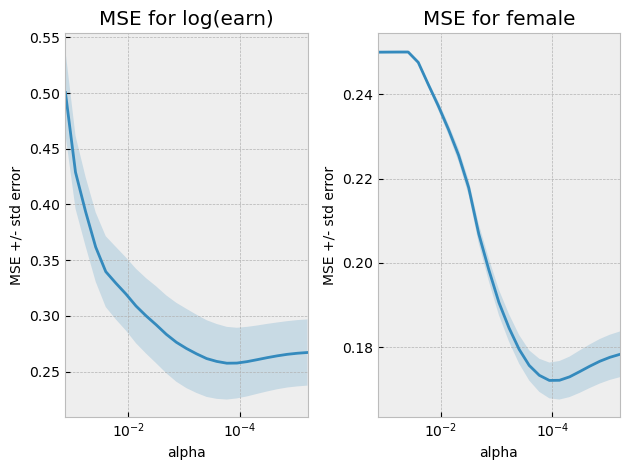

In [16]:
fig, ax = plt.subplots(1,2)

def plotlassocv(l, ax) :
    alphas = l.alphas_
    mse = l.mse_path_.mean(axis=1)
    std_error = l.mse_path_.std(axis=1)
    ax.plot(alphas,mse)
    ax.fill_between(alphas, mse + std_error, mse - std_error, alpha=0.2)

    ax.set_ylabel('MSE +/- std error')
    ax.set_xlabel('alpha')
    ax.set_xlim([alphas[0], alphas[-1]])
    ax.set_xscale("log")
    return(ax)

ax[0] = plotlassocv(lassoy,ax[0])
ax[0].set_title("MSE for log(earn)")
ax[1] = plotlassocv(lassod,ax[1])
ax[1].set_title("MSE for female")
fig.tight_layout()

# there are theoretical reasons to choose a smaller regularization
# than the one that minimizes cv. BUT THIS WAY OF CHOOSING IS ARBITRARY AND MIGHT BE WRONG
def pickalpha(lassocv) :
    imin = np.argmin(lassocv.mse_path_.mean(axis=1))
    msemin = lassocv.mse_path_.mean(axis=1)[imin]
    se = lassocv.mse_path_.std(axis=1)[imin]
    alpha= min([alpha for (alpha, mse) in zip(lassocv.alphas_, lassocv.mse_path_.mean(axis=1)) if mse<msemin+se])
    return(alpha)

alphay = pickalpha(lassoy)
alphad = pickalpha(lassod)

In [17]:
# show results
pl_lasso = partial_linear(logearn, female, X,
                          linear_model.Lasso(alpha=lassoy.alpha_),
                          linear_model.Lasso(alpha=lassod.alpha_))
pl_lasso[0].summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                      y   R-squared (uncentered):                   0.009
Model:                            OLS   Adj. R-squared (uncentered):              0.009
Method:                 Least Squares   F-statistic:                              107.2
Date:                Tue, 23 May 2023   Prob (F-statistic):                    4.91e-25
Time:                        12:43:35   Log-Likelihood:                         -9718.3
No. Observations:               13052   AIC:                                  1.944e+04
Df Residuals:                   13051   BIC:                                  1.945e+04
Df Model:                           1                                                  
Covariance Type:                  HC0                                                  
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
x1            -0.1160      0.011    -10.356      0.000      -0.138      -0.094
==============================================================================
Omnibus:                     6939.182   Durbin-Watson:                   1.959
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           410073.398
Skew:                          -1.777   Prob(JB):                         0.00
Kurtosis:                      30.229   Cond. No.                         1.00
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors are heteroscedasticity robust (HC0)
"""

/var/folders/6q/vdn5r7zd03v32cbm86sn2p980000gn/T/ipykernel_2277/3039950914.py:16: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(pl[2][female==0], hist = True, kde = False,
/var/folders/6q/vdn5r7zd03v32cbm86sn2p980000gn/T/ipykernel_2277/3039950914.py:19: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distp

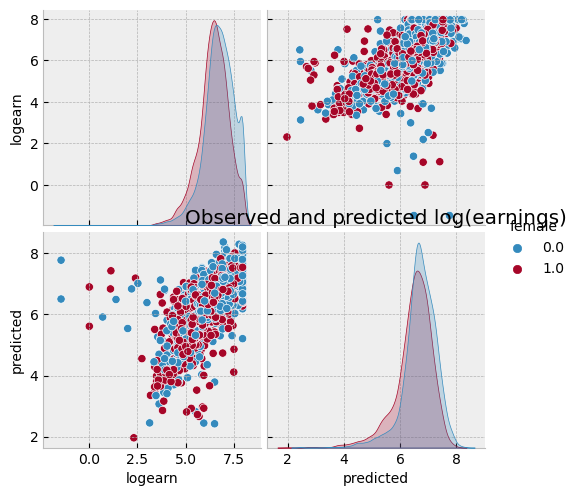

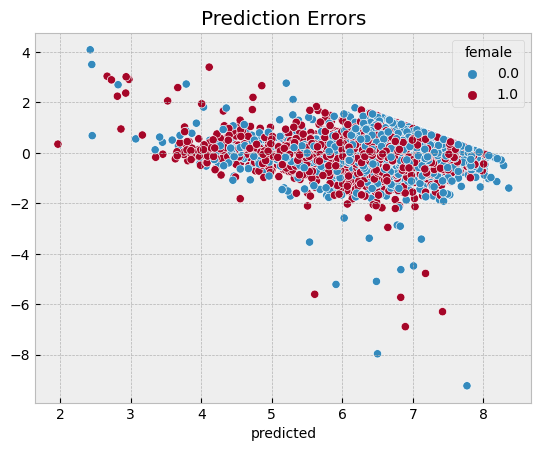

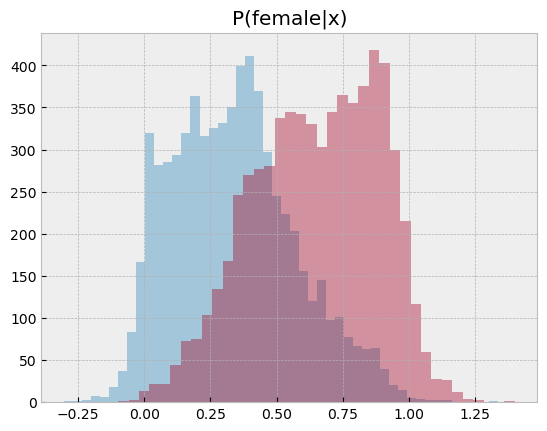

In [18]:
import seaborn as sns
# Visualize predictions
def plotpredictions(pl) :
    df = pd.DataFrame({"logearn":logearn,
                       "predicted":pl[1],
                       "female":female,
                       "P(female|x)":pl[2]})
    sns.pairplot(df, vars=["logearn","predicted"], hue="female")
    plt.title("Observed and predicted log(earnings)")

    plt.figure()
    sns.scatterplot(x = df.predicted, y = df.logearn-df.predicted, hue=df.female)
    plt.title("Prediction Errors")

    plt.figure()
    sns.distplot(pl[2][female==0], hist = True, kde = False,
                 kde_kws = {'shade': True, 'linewidth': 3},
                 label = "Male")
    sns.distplot(pl[2][female==1], hist = True, kde = False,
                 kde_kws = {'shade': True, 'linewidth': 3},
                 label = "Female")
    plt.title('P(female|x)')
plotpredictions(pl_lasso)

We see that the gender earnings gap is
12.4%, conditional on hours, age, race, location, education,
union membership, industry, and occupation.
Compared to the gap conditional on only hours, differences in other observable characteristics in the CPS seem unable explain much of the gender earnings gap.

We can repeat the same procedure with another machine learning method
in place of lasso. Let’s try it with neural networks.

In [19]:
from sklearn import neural_network
from sklearn import preprocessing, pipeline, model_selection

nnp = pipeline.Pipeline(steps=[
    ("scaling", preprocessing.StandardScaler()),
    ("nn", neural_network.MLPRegressor((50,), activation="logistic",
                                       verbose=False, solver="adam",
                                       max_iter=400, early_stopping=True,
                                       validation_fraction=0.15))
])

nndcv = model_selection.GridSearchCV(estimator=nnp, scoring= 'neg_mean_squared_error', cv=4,
                                     param_grid = {'nn__alpha': np.exp(np.linspace(-5,5, 10))},
                                     return_train_score=True, verbose=True, refit=False,
                                     ).fit(X,female)

Fitting 4 folds for each of 10 candidates, totalling 40 fits


In [20]:
nnycv = model_selection.GridSearchCV(estimator=nnp, scoring= 'neg_mean_squared_error', cv=4,
                                     param_grid = {'nn__alpha': np.exp(np.linspace(-5,5, 10))},
                                     return_train_score=True, verbose=True, refit=False,
                                     ).fit(X,logearn)

Fitting 4 folds for each of 10 candidates, totalling 40 fits


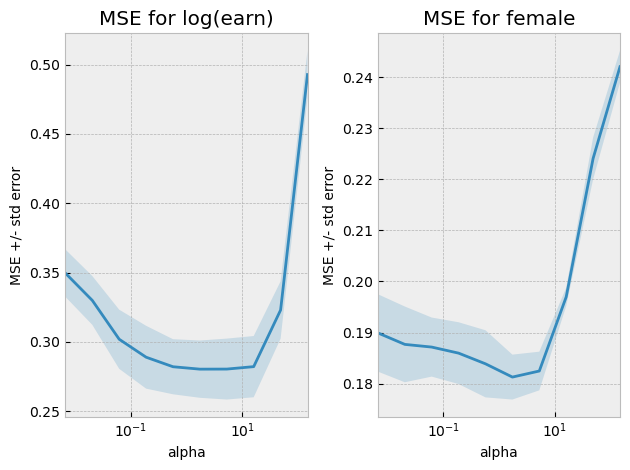

In [21]:
fig, ax = plt.subplots(1,2)

def plotgridcv(g, ax) :
    alphas = g.cv_results_["param_nn__alpha"].data.astype(float)
    mse = -g.cv_results_["mean_test_score"]
    std_error = g.cv_results_["std_test_score"]
    ax.plot(alphas,mse)
    ax.fill_between(alphas, mse+std_error, mse-std_error, alpha=0.2)

    ax.set_ylabel('MSE +/- std error')
    ax.set_xlabel('alpha')
    ax.set_xlim([alphas[0], alphas[-1]])
    ax.set_xscale("log")
    return(ax)

ax[0] = plotgridcv(nnycv,ax[0])
ax[0].set_title("MSE for log(earn)")
ax[1] = plotgridcv(nndcv,ax[1])
ax[1].set_title("MSE for female")
fig.tight_layout()

# there are theoretical reasons to choose a smaller regularization
# than the one that minimizes cv. BUT THIS WAY OF CHOOSING IS ARBITRARY AND MAYBE WRONG
def pickalphagridcv(g) :
    alphas = g.cv_results_["param_nn__alpha"].data
    mses = g.cv_results_["mean_test_score"]
    imin = np.argmin(mses)
    msemin = mses[imin]
    se = g.cv_results_["std_test_score"][imin]
    alpha= min([alpha for (alpha, mse) in zip(alphas, mses) if mse<msemin+se])
    return(alpha)

alphaynn = pickalphagridcv(nnycv)
alphadnn = pickalphagridcv(nndcv)

In [22]:
# show results
nny = nnp
nny.set_params(nn__alpha = alphaynn)
nnd = nnp
nnd.set_params(nn__alpha = alphadnn)
pl_nn = partial_linear(logearn, female, X,
                       nny, nnd)
pl_nn[0].summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                      y   R-squared (uncentered):                   0.016
Model:                            OLS   Adj. R-squared (uncentered):              0.016
Method:                 Least Squares   F-statistic:                              207.5
Date:                Tue, 23 May 2023   Prob (F-statistic):                    1.10e-46
Time:                        12:49:20   Log-Likelihood:                         -13716.
No. Observations:               13052   AIC:                                  2.743e+04
Df Residuals:                   13051   BIC:                                  2.744e+04
Df Model:                           1                                                  
Covariance Type:                  HC0                                                  
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
x1            -0.1775      0.012    -14.405      0.000      -0.202      -0.153
==============================================================================
Omnibus:                     4200.730   Durbin-Watson:                   1.709
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            48078.505
Skew:                          -1.214   Prob(JB):                         0.00
Kurtosis:                      12.084   Cond. No.                         1.00
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors are heteroscedasticity robust (HC0)
"""

/var/folders/6q/vdn5r7zd03v32cbm86sn2p980000gn/T/ipykernel_2277/3039950914.py:16: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(pl[2][female==0], hist = True, kde = False,
/var/folders/6q/vdn5r7zd03v32cbm86sn2p980000gn/T/ipykernel_2277/3039950914.py:19: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distp

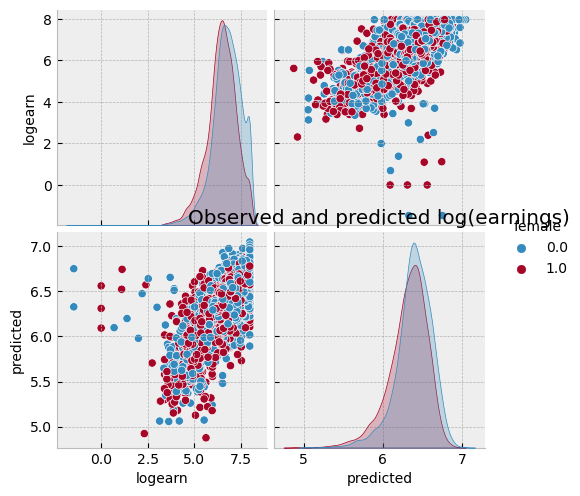

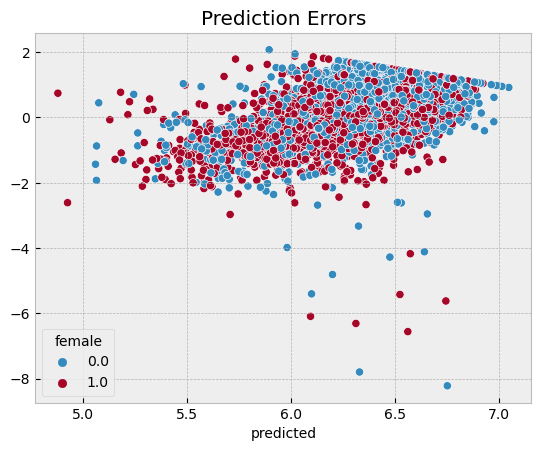

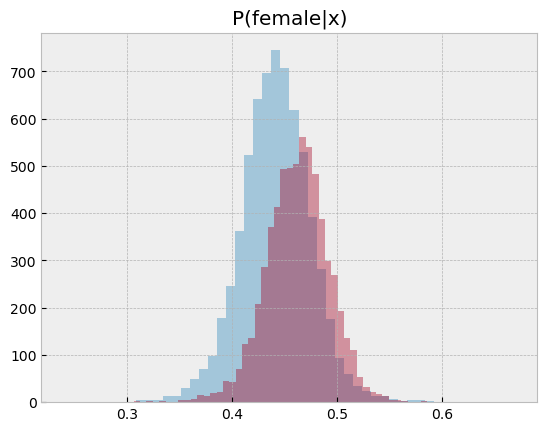

In [23]:
plotpredictions(pl_nn)

In [24]:
summary_col([pl_lasso[0], pl_nn[0]], model_names=["Lasso", "Neural Network"] ,stars=False)

,Lasso,Neural Network
x1,-0.1160,-0.1775
,(0.0112),(0.0123)
R-squared,0.0089,0.0157
R-squared Adj.,0.0088,0.0156


## References

<a id='id13'></a>
\[mlKLMO15\] Jon Kleinberg, Jens Ludwig, Sendhil Mullainathan, and Ziad Obermeyer. Prediction policy problems. *American Economic Review*, 105(5):491–95, May 2015. URL: [http://www.aeaweb.org/articles?id=10.1257/aer.p20151023](http://www.aeaweb.org/articles?id=10.1257/aer.p20151023), [doi:10.1257/aer.p20151023](https://doi.org/10.1257/aer.p20151023).
